## Batch Normalization

Batch normalization is a technique in neural networks to improve training speed and stability. It normalizes the inputs to a layer within a mini-batch, ensuring that they have a mean of 0 and a standard deviation of 1. After normalization, the technique introduces two learnable parameters, a scaling factor ($ \gamma $) and a shift factor ($ \beta $), to allow the network to learn the optimal scale and offset for each feature.

### Benefits:
1. **Improved Training Speed**: It allows higher learning rates by reducing the risk of exploding or vanishing gradients.
2. **Regularization Effect**: It adds slight noise to the training process due to mini-batch calculations, which can reduce overfitting.
3. **Reduced Sensitivity to Initialization**: It alleviates the need for careful weight initialization.

### Formula:
For a mini-batch $ x = \{x_1, x_2, \dots, x_m\} $:
1. Compute batch mean: $ \mu = \frac{1}{m} \sum_{i=1}^m x_i $
2. Compute batch variance: $ \sigma^2 = \frac{1}{m} \sum_{i=1}^m (x_i - \mu)^2 $
3. Normalize: $ \hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} $
4. Scale and shift: $ y_i = \gamma \hat{x}_i + \beta $

Here, $ \epsilon $ is a small constant to avoid division by zero.

---

## Why batch_normalization has 128 parameters?
```
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
```

The 128 parameters in the `batch_normalization` layer represent the learnable parameters of the layer: **scale ($ \gamma $)** and **shift ($ \beta $)**. These parameters allow the model to adjust the normalized values during training.

### Explanation:
1. **Input Shape to Batch Normalization**: `(None, 32, 32, 32)`
   - The last dimension, `32`, represents the number of channels (or filters) from the preceding `Conv2D` layer.

2. **Learnable Parameters**:
   - For each channel, batch normalization learns:
     - $ \gamma $ (scale parameter): 32 parameters
     - $ \beta $ (shift parameter): 32 parameters
   - Total learnable parameters = \( 32 + 32 = 64 \).

3. **Non-learnable Parameters**:
   - Batch normalization also maintains two moving statistics for each channel:
     - **Moving mean**: 32 values
     - **Moving variance**: 32 values
   - These are not updated by backpropagation but are used during inference.
   - Total non-learnable parameters = \( 32 + 32 = 64 \).

### Total Parameters:
- Learnable parameters: \( 64 \)
- Non-learnable parameters: \( 64 \)
- **Total parameters: \( 64 + 64 = 128 \)**

---

## Can you elaborate on moving mean and variance?
The **moving mean** and **moving variance** in batch normalization are non-learnable parameters used to keep track of the mean and variance of the activations during training. They play a critical role during **inference (testing)** when batch statistics are no longer computed dynamically.

### What are moving mean and moving variance?
1. **Moving Mean ($ \mu_{\text{moving}} $)**:
   - It is an estimate of the mean of the layer's activations across the entire dataset, computed and updated during training.
   - During **training**, for each mini-batch, the mean of the activations ($ \mu_{\text{batch}} $) is calculated. This batch mean is then used to update the moving mean:
     $$
     \mu_{\text{moving}} = (1 - \text{momentum}) \cdot \mu_{\text{batch}} + \text{momentum} \cdot \mu_{\text{moving}}
     $$
   - The `momentum` parameter (default ~0.99 or 0.9) controls how much of the previous moving mean is retained.

2. **Moving Variance ($ \sigma_{\text{moving}}^2 $)**:
   - Similar to the moving mean, this tracks the variance of the activations across the dataset.
   - It is updated using the batch variance ($ \sigma_{\text{batch}}^2 $) computed for each mini-batch:
     $$
     \sigma_{\text{moving}}^2 = (1 - \text{momentum}) \cdot \sigma_{\text{batch}}^2 + \text{momentum} \cdot \sigma_{\text{moving}}^2
     $$

### Purpose:
- During **training**, the mini-batch mean and variance are used to normalize the activations.
- During **inference**, the moving mean and moving variance are used instead, since the test data may not be passed in mini-batches, and computing statistics dynamically is infeasible.

### Key Points:
- The moving mean and variance are **not updated by backpropagation**; they are updated directly during forward passes in training.
- They do not count as learnable parameters since the model does not optimize them during training.

### Practical Example:
- Suppose during training, in the first few mini-batches, the mean and variance of a channel's activations are as follows:
  - Batch 1: $ \mu_{\text{batch}} = 0.5 $, $ \sigma_{\text{batch}}^2 = 0.25 $
  - Batch 2: $ \mu_{\text{batch}} = 0.6 $, $ \sigma_{\text{batch}}^2 = 0.2 $
  - With a momentum of 0.9, the moving estimates are updated as:
    $$
    \mu_{\text{moving}} = 0.9 \cdot \mu_{\text{moving (prev)}} + 0.1 \cdot \mu_{\text{batch}}
    $$
    $$
    \sigma_{\text{moving}}^2 = 0.9 \cdot \sigma_{\text{moving (prev)}}^2 + 0.1 \cdot \sigma_{\text{batch}}^2
    $$

By the end of training, the moving mean and variance provide a stable estimate of the activation statistics for inference.

---

## Batch Normalization in Action

In [116]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from matplotlib.patches import Rectangle

### Creating dummy images for demo

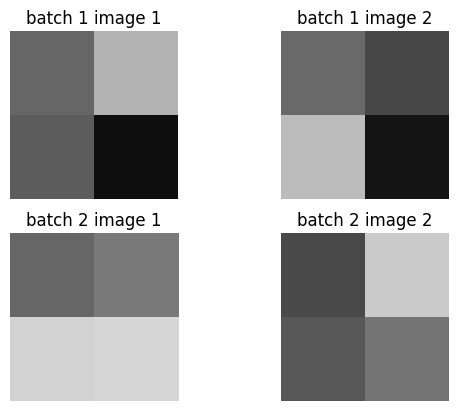

In [213]:
np.random.seed(42)
batch_1 = np.random.randint(0, 255, (2, 2, 2, 1))  # batch 1 having 2 images
batch_2 = np.random.randint(0, 255, (2, 2, 2, 1))  # batch 2 having 2 images
batches = [batch_1, batch_2]
fig, axes = plt.subplots(2, 2)
for i, batch in enumerate(batches):
    for j, image in enumerate(batch):
        ax = axes[i][j]
        ax.imshow(image, cmap="gray", vmin=0, vmax=255)
        ax.set_title(f"batch {i+1} image {j+1}")
        ax.axis("off")

## Calculation of moving mean and moving variance

In [228]:
bn_layer = tf.keras.layers.BatchNormalization()
bn_layer.build(input_shape=(None, 2, 2, 1))
for batch in batches:
    bn_layer(batch, training=True)
    gamma, beta, mean, var = bn_layer.get_weights()
    print(f"gamma={gamma.tolist()}\nbeta={beta.tolist()}\nmean={mean.tolist()}\nvar={var.tolist()}\n")

gamma=[1.0]
beta=[0.0]
mean=[0.9649999737739563]
var=[36.775001525878906]

gamma=[1.0]
beta=[0.0]
mean=[2.3628499507904053]
var=[66.109130859375]



**Internal working**

In [229]:
def calc_running_mean(inpt, running_mean_till_now, momentum=0.99):
    batch_mean = np.mean(inpt)
    running_mean = momentum * running_mean_till_now + (1 - momentum) * batch_mean
    return running_mean

def calc_running_var(inpt, running_var_till_now, momentum=0.99):
    batch_var = np.var(inpt)
    running_var = momentum * running_var_till_now + (1 - momentum) * batch_var
    return running_var

In [232]:
running_mean_till_now = 0
running_var_till_now = 1
for batch in batches:
    running_mean_till_now = calc_running_mean(batch, running_mean_till_now)
    running_var_till_now = calc_running_var(batch, running_var_till_now)
    print(f"{running_mean_till_now=}\n{running_var_till_now=}\n")

running_mean_till_now=0.9650000000000009
running_var_till_now=36.775000000000034

running_mean_till_now=2.362850000000002
running_var_till_now=66.10912500000006



## Normalization of inputs to the BatchNormalization Layer

In [269]:
bn_layer = tf.keras.layers.BatchNormalization()
bn_layer.build(input_shape=(None, 2, 2, 1))
batch_mod = bn_layer(batches[0], training=True)  # modifier batch after normalization, scale and shift
batch_mod

<tf.Tensor: shape=(2, 2, 2, 1), dtype=float32, numpy=
array([[[[ 0.0919416 ],
         [ 1.3791243 ]],

        [[-0.07522488],
         [-1.3791242 ]]],


       [[[ 0.15880823],
         [-0.42627478]],

        [[ 1.5295743 ],
         [-1.2788242 ]]]], dtype=float32)>

**Internal working**

In [271]:
init_gamma = 1
init_beta = 0
batch_norm = (batches[0]-batches[0].mean())/np.std(batches[0])
batch_mod = batch_norm * init_gamma + init_beta
batch_norm

array([[[[ 0.09194163],
         [ 1.37912439]],

        [[-0.07522497],
         [-1.37912439]]],


       [[[ 0.15880826],
         [-0.42627481]],

        [[ 1.52957432],
         [-1.27882443]]]])

![](../assets/images/batch_norm.jpg)